# *Libraries*

In [13]:
import os
import tensorflow as tf
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# *Load data*

In [14]:
def load() :

    # Hämta den aktuella arbetskatalogen
    current_dir = os.getcwd()

    # Gå en nivå bakåt från nuvarande katalog
    parent_dir = os.path.dirname(current_dir)

    # Definiera relativa vägar baserat på den överordnade katalogen
    train_dir = os.path.join(parent_dir, "dataset", "CNN_Input", "train")
    test_dir = os.path.join(parent_dir, "dataset", "CNN_Input", "test")


    # Load train data
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=(150, 150),
        batch_size=16,
        label_mode='categorical'
    )

    # Load test data
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        image_size=(150, 150),
        batch_size=16,
        label_mode='categorical'  # Categorical labels for multi-class classification
    )
    
    return test_data, train_data

# *Plot 8 images*

In [15]:
def plot_img(train_data, class_names):
    plt.figure(figsize=(8, 5))
    for images, labels in train_data.take(1):  # Take one batch from the dataset
        for i in range(8):  # Plot up to 8 images
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i]).numpy()])
            plt.axis("off")
        plt.subplots_adjust(hspace=0, wspace=0)
        plt.show()

# *Data preparation*

In [16]:
def normalize_img(train_data, test_data):
    """Normalize the data to have a value between 0 and 1"""
    def normalize(image, label):
        image = image / 255.0  
        return image, label  
        
    # Normalization to both train and test datasets
    train_data_norm = train_data.map(normalize)
    test_data_norm = test_data.map(normalize)

    return test_data_norm, train_data_norm

# *Noise functions*

In [17]:
def add_gaussian_noise(image, label):
    """Adds Gaussian noise to the image."""
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=2.0)
    noisy_image = image + noise
    return noisy_image, label

def add_salt_and_pepper_noise(image, label, salt_prob=0.04, pepper_prob=0.04):
    """Adds salt and pepper noise to the image."""
    # Generate random noise for each pixel
    random_vals = tf.random.uniform(shape=tf.shape(image), minval=0.0, maxval=1.0)
    salt = random_vals < salt_prob
    image = tf.where(salt, 255.0, image)
    
    pepper = random_vals > (1.0 - pepper_prob)
    image = tf.where(pepper, 0.0, image)  # Set selected pixels to 0 (black)
    return image, label  # Return noisy image with its label
    

# *Build and Compile CNN*

In [18]:
# Build the CNN model for multi-class classification
def build_cnn_model():
    """Build the CNN model"""
    model = models.Sequential([
        layers.InputLayer(shape=(150, 150, 3)),  # Input shape (150x150x3)
        
        # Convolutional layers with max pooling
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten the output and pass through dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 output units, one for each class (good, bad, contaminated, etc.)
    ])
    
    # Compile the model with sparse categorical crossentropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# *Train model*

In [19]:
# Stop training early if no improvement in validation loss for 5 epochs

def train_model(model, train_data_norm, test_data_norm):

    callbacks = [  
        # Stop training early if no improvement in validation loss for 5 epochs
         EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            restore_best_weights=True
        ),
        # Reduce learning rate if validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2,
            patience=3 
        )
    ]
    
    history = model.fit(
        train_data_norm,
        epochs=70,
        validation_data=test_data_norm,
        callbacks=callbacks
    )
    return history

# *Plotting Training and Validation Figures*

In [20]:
def plot_metrics(history): # Insert parameter name

    # Plot traning and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot traning and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# *Main*

Found 83 files belonging to 4 classes.
Found 62 files belonging to 4 classes.


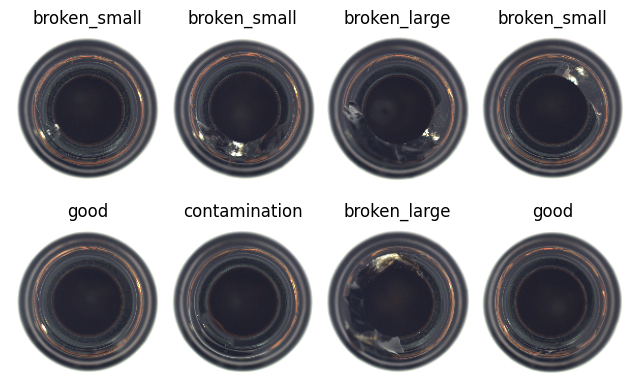

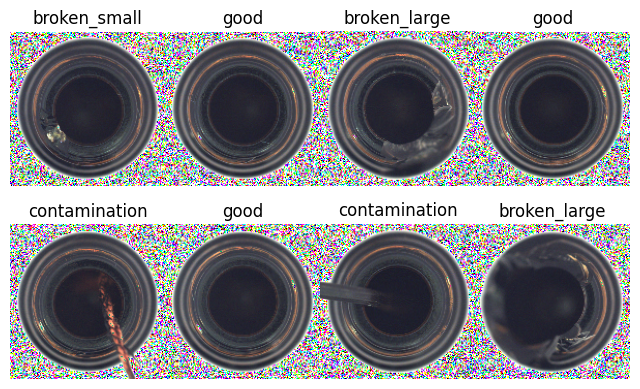

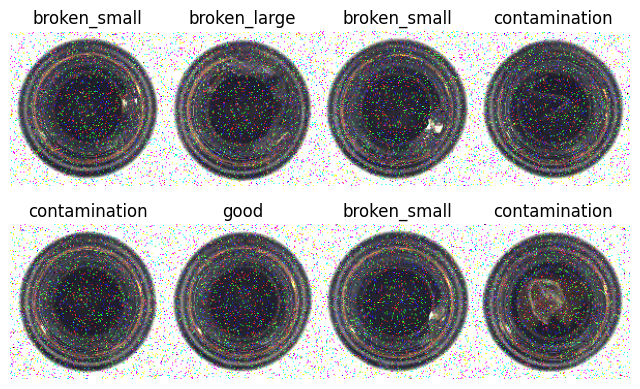

6
6
6
18


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,428 (622.77 KB)

 Trainable params: 159,428 (622.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.2778 - loss: 1.3985 - val_accuracy: 0.2581 - val_loss: 1.3862 - learning_rate: 0.0010
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.3159 - loss: 1.3837 - val_accuracy: 0.2742 - val_loss: 1.3799 - learning_rate: 0.0010
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.2602 - loss: 1.3879 - val_accuracy: 0.2581 - val_loss: 1.3793 - learning_rate: 0.0010
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.2894 - loss: 1.3749 - val_accuracy: 0.2742 - val_loss: 1.3774 - learning_rate: 0.0010
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.2890 - loss: 1.3647 - val_accuracy: 0.4435 - val_loss: 1.3477 - learning_rate: 0.0010
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5073 - loss: 1.3246 - val_accuracy: 0.2742 - val_loss: 1.3477 - learning_rate: 0.0010
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.3377 - loss: 1.3249 - val_

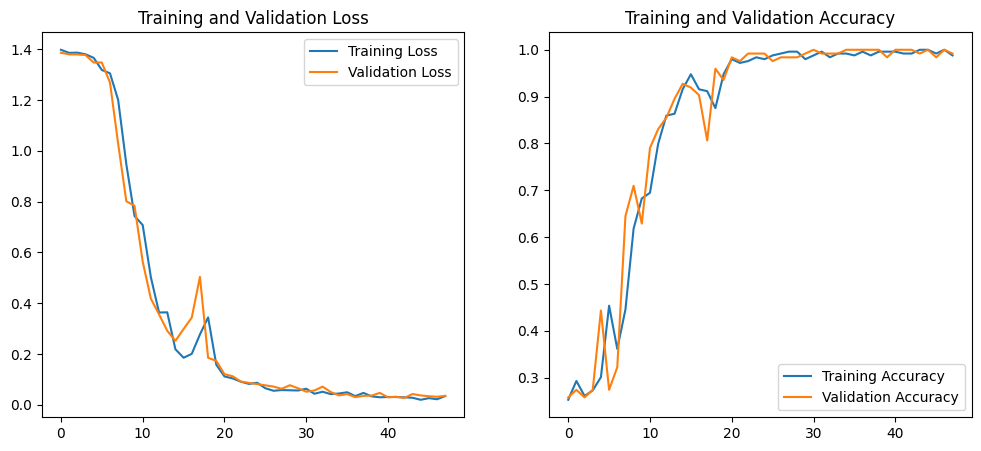

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9954 - loss: 0.0212
Test Loss: 0.044126641005277634
Test Accuracy: 98.39%


In [21]:
test_data, train_data = load()
class_names = train_data.class_names

g_noisy_train_data = train_data.map(add_gaussian_noise)
snp_noisy_train_data = train_data.map(add_salt_and_pepper_noise)

combined_train_data = train_data.concatenate(g_noisy_train_data).concatenate(snp_noisy_train_data)

plot_img(train_data, class_names)
plot_img(g_noisy_train_data, class_names)
plot_img(snp_noisy_train_data, class_names)

print(len(train_data))
print(len(snp_noisy_train_data))
print(len(g_noisy_train_data))
print(len(combined_train_data))

percentage_noisy_images = 0.2
total_test_images = len(test_data) * 16  # Total images in test data
num_noisy_images = int(total_test_images * percentage_noisy_images)

g_noisy_test_data = test_data.take(num_noisy_images).map(add_gaussian_noise)
snp_noisy_test_data = test_data.take(num_noisy_images).map(add_salt_and_pepper_noise)

remaining_test_data = test_data.skip(num_noisy_images)
combined_test_data = g_noisy_test_data.concatenate(remaining_test_data)
combined_test_data = combined_test_data.concatenate(snp_noisy_test_data)

test_data_norm, train_data_norm = normalize_img(combined_train_data, combined_test_data)
model = build_cnn_model()
model.summary()
history = train_model(model, train_data_norm, test_data_norm)
plot_metrics(history)

test_loss, test_accuracy = model.evaluate(test_data_norm)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")